In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2023-06-20 21:40:17.261449: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 21:40:17.284010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 21:40:17.284370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 21:40:17.743232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
2.12.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from multiprocessing import Process

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout, Flatten, MaxPool2D, MaxPooling2D
from keras.callbacks import EarlyStopping, History

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_classes = len(class_names)

In [5]:
def plot_fashion_mnist():
    n_rows = 4
    n_cols = 10
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[y_train[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()
    
# plot_fashion_mnist()

In [9]:
def create_model():
    model = Sequential()
    CONV_DROPOUT = 0.2
    DENSE_DROPOUT = 0.5
    KERNEL_SIZE = 3
    
    model.add(Conv2D(32, kernel_size=KERNEL_SIZE, activation='relu', input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=KERNEL_SIZE, padding="same", strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(CONV_DROPOUT))
    
    model.add(Conv2D(64, kernel_size=KERNEL_SIZE, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=KERNEL_SIZE, padding="same", strides=2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(CONV_DROPOUT))
   
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(DENSE_DROPOUT))
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    model.summary()
    return model

keras.backend.clear_session()
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        1

In [10]:
def train(model):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return model.fit(X_train, y_train, epochs=20,
                     use_multiprocessing=False,
                     validation_data=(X_valid, y_valid),
                     callbacks=[early_stopping])

    
start = time.time()
history = train(model)
end = time.time()
print(f"Elapsed time: {end - start} s")
model.evaluate(X_test, y_test)

Epoch 1/20
1719/1719 [==============================] - 15s 8ms/step - loss: 0.5159 - accuracy: 0.8189 - val_loss: 0.2985 - val_accuracy: 0.8902
Epoch 2/20
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3408 - accuracy: 0.8783 - val_loss: 0.2699 - val_accuracy: 0.8998
Epoch 3/20
1719/1719 [==============================] - 16s 10ms/step - loss: 0.2946 - accuracy: 0.8963 - val_loss: 0.2709 - val_accuracy: 0.9002
Epoch 4/20
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2647 - accuracy: 0.9069 - val_loss: 0.2098 - val_accuracy: 0.9232
Epoch 5/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2471 - accuracy: 0.9118 - val_loss: 0.2247 - val_accuracy: 0.9198
Epoch 6/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.2281 - accuracy: 0.9189 - val_loss: 0.2076 - val_accuracy: 0.9218
Epoch 7/20
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2133 - accuracy: 0.9242 - val_loss: 0.2018 - va

[0.21552248299121857, 0.9316999912261963]

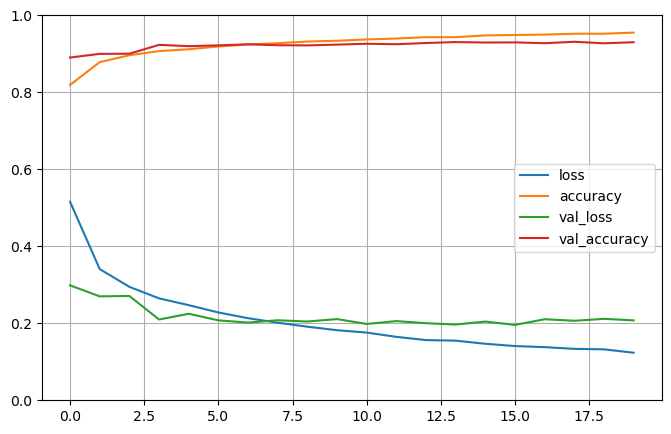

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()